## Machine learning Algorithm Trader

In this project, we will be using the OANDA v20 REST API  

<img style="float: left;" src="./images/api.png">




# Why forex over stocks?


![3advantage](./images/lvts.png)

### Liquidity  
The forex market is the largest and most liquid financial market. Daily activity often exceeds 4 trillion USD, with over 1.5 trillion of that conducted in the form of spot trading.


### Volatility  
Volatility boosts opportunity due to exchange rate fluctuations. Forex trading operates 24 hours a day, 5 days a week. The greatest liquidity occurs when operational hours in multiple time zones overlap.


### Tight Spreads  
Spreads in the forex market tend to be tighter (less), than the spreads applied to other, securities such as stocks. This makes OTC forex trading one of the most cost - effective means of investment trading.

In [1]:
import pandas as pd
import numpy as np
import tpqoa
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import random
import numpy as np
import tensorflow as tf
from keras.layers import Dense, Dropout
from keras.models import Sequential, load_model
from keras.regularizers import l1, l2
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import GridSearchCV
import pickle as pkl
import shap
import seaborn as sns
import joblib
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix


plt.style.use("seaborn")

pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

In [2]:
df = pd.read_pickle('datasets/eur_usd.pkl')
#train_s = pd.read_pickle("datasets/train_s.pkl")
#test_s = pd.read_pickle("datasets/test_s.pkl")
#train = pd.read_pickle("datasets/train.pkl")
#test = pd.read_pickle("datasets/test.pkl")
#X = pd.read_pickle("datasets/X.pkl")
#y = pd.read_pickle("datasets/y.pkl")
#cols = [
#    'dir_lag_1', 'dir_lag_2', 'dir_lag_3', 'dir_lag_4', 'dir_lag_5',
 #   'sma_lag_1', 'sma_lag_2', 'sma_lag_3', 'sma_lag_4', 'sma_lag_5',
  #  'bol1_lag_1', 'bol1_lag_2', 'bol1_lag_3', 'bol1_lag_4', 'bol1_lag_5',
   # 'bol2_lag_1', 'bol2_lag_2', 'bol2_lag_3', 'bol2_lag_4', 'bol2_lag_5',
   # 'min_lag_1', 'min_lag_2', 'min_lag_3', 'min_lag_4', 'min_lag_5',
   # 'max_lag_1', 'max_lag_2', 'max_lag_3', 'max_lag_4', 'max_lag_5',
   # 'mom_lag_1', 'mom_lag_2', 'mom_lag_3', 'mom_lag_4', 'mom_lag_5',
    #'vol_lag_1', 'vol_lag_2', 'vol_lag_3', 'vol_lag_4', 'vol_lag_5'
#]

In [3]:
df = df.rename(columns={'o': 'open', 'h': 'high', 'l':'low', 'c': 'close'})
df = df.close.to_frame()
#creating a column for the log returns for the 1min interval
df["returns"] = np.log(df["close"].div(df["close"].shift(1)))
df["dir"] = np.where(df["returns"] > 0, 1, 0) # this indicates of returns are positive or negative
df.dropna(inplace = True)

In [4]:
df

,close,returns,dir
time,,,
2020-09-01 00:05:00,1.19451,0.000126,1
2020-09-01 00:10:00,1.19472,0.000176,1
2020-09-01 00:15:00,1.19468,-0.000033,0
2020-09-01 00:20:00,1.19448,-0.000167,0
2020-09-01 00:25:00,1.19438,-0.000084,0
...,...,...,...
2022-08-30 23:35:00,1.00218,-0.000140,0
2022-08-30 23:40:00,1.00244,0.000259,1
2022-08-30 23:45:00,1.00244,0.000000,0


In [5]:
window = 25 #based on a 50 period

df["sma"] = df['close'].rolling(window).mean() - df['close'].rolling(50).mean() #distance between SMA50 - SMA150
#df["bol"] = (df['close'] - df['close'].rolling(window).mean()) / df['close'].rolling(window).std() #Bollinger band 
df["bol1"] = df['close'].rolling(window).mean() + df['close'].rolling(window).std()* 2
df["bol2"] = df['close'].rolling(window).mean() - df['close'].rolling(window).std()* 2
df["min"] = df['close'].rolling(window).min() / df['close'] - 1  #rolling min divided by current price -1
df["max"] = df['close'].rolling(window).max() / df['close'] - 1  #rolling max divided by current price -1
df["mom"] = df["returns"].rolling(3).mean()                      #rolling mean
df["vol"] = df["returns"].rolling(window).std()                  #rolling std deviation (volitility feature)
df.dropna(inplace = True)

In [6]:
df

,close,returns,dir,sma,bol1,bol2,min,max,mom,vol
time,,,,,,,,,,
2020-09-01 04:10:00,1.19937,0.000008,1,0.001830,1.200514,1.196878,-0.002109,0.000175,0.000114,0.000408
2020-09-01 04:15:00,1.19928,-0.000075,0,0.001831,1.200458,1.197126,-0.002035,0.000250,0.000117,0.000407
2020-09-01 04:20:00,1.19926,-0.000017,0,0.001837,1.200351,1.197427,-0.001918,0.000267,-0.000028,0.000407
2020-09-01 04:25:00,1.19911,-0.000125,0,0.001834,1.200197,1.197753,-0.001693,0.000392,-0.000072,0.000409
2020-09-01 04:30:00,1.19936,0.000208,1,0.001828,1.200007,1.198125,-0.001893,0.000183,0.000022,0.000410
...,...,...,...,...,...,...,...,...,...,...
2022-08-30 23:35:00,1.00218,-0.000140,0,0.000041,1.002333,1.001435,-0.000649,0.000140,0.000013,0.000118
2022-08-30 23:40:00,1.00244,0.000259,1,0.000066,1.002406,1.001426,-0.000908,0.000000,0.000086,0.000127
2022-08-30 23:45:00,1.00244,0.000000,0,0.000088,1.002464,1.001434,-0.000908,0.000000,0.000040,0.000127


In [7]:
# sma_plt = df[['close','sma']]
sma_plt = df[['close']].copy()
sma_plt["SMA_S"] = sma_plt.close.rolling(50).mean()
sma_plt["SMA_L"] = sma_plt.close.rolling(150).mean()


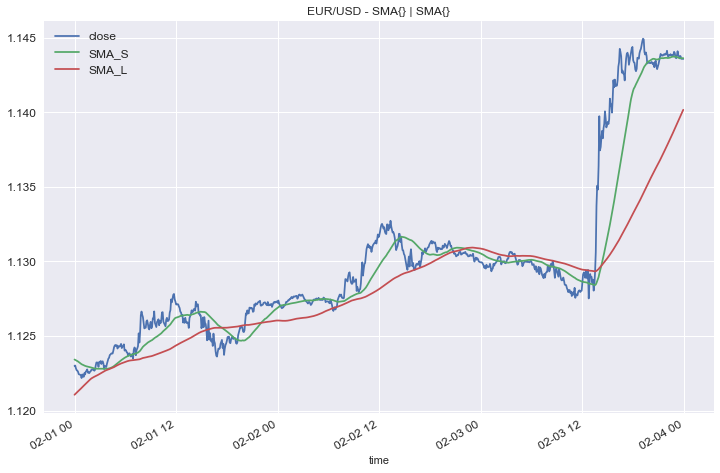

In [8]:
sma_plt.loc["2022-02-01" : "2022-02-3"].plot(figsize = (12, 8), title = "EUR/USD - SMA{} | SMA{}", fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

In [9]:
# bol_plt = df[['close','vol']]
sma_plt["bol1"] = df[['bol1']].copy()
sma_plt["bol2"]= df[['bol2']].copy()

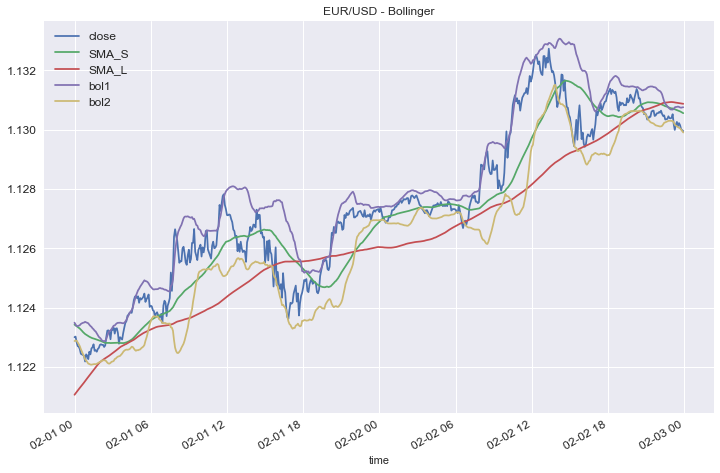

In [10]:
sma_plt.loc["2022-02-01" : "2022-02-02"].plot(figsize = (12, 8), title = "EUR/USD - Bollinger", fontsize = 12)
plt.legend(fontsize = 12)
plt.show()

# Adding Lag features

In [11]:
lags = 5

In [12]:
cols = []
features = ["dir", "sma", "bol1", "bol2", "min", "max", "mom", "vol"]

In [13]:
for f in features:
        for lag in range(1, lags + 1):
            col = "{}_lag_{}".format(f, lag)
            df[col] = df[f].shift(lag)
            cols.append(col)
df.dropna(inplace = True)

In [14]:
df

,close,returns,dir,sma,bol1,bol2,min,max,mom,vol,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,bol1_lag_1,bol1_lag_2,bol1_lag_3,bol1_lag_4,bol1_lag_5,bol2_lag_1,bol2_lag_2,bol2_lag_3,bol2_lag_4,bol2_lag_5,min_lag_1,min_lag_2,min_lag_3,min_lag_4,min_lag_5,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-01 04:35:00,1.19911,-0.000208,0,0.001814,1.199603,1.198691,-0.000284,0.000392,-0.000042,0.000414,1.0,0.0,0.0,0.0,1.0,0.001828,0.001834,0.001837,0.001831,0.001830,1.200007,1.200197,1.200351,1.200458,1.200514,1.198125,1.197753,1.197427,1.197126,1.196878,-0.001893,-0.001693,-0.001918,-0.002035,-0.002109,0.000183,0.000392,0.000267,0.000250,0.000175,0.000022,-7.226799e-05,-2.779376e-05,1.167572e-04,1.139682e-04,0.000410,0.000409,0.000407,0.000407,0.000408
2020-09-01 04:40:00,1.19912,0.000008,1,0.001714,1.199595,1.198688,-0.000292,0.000384,0.000003,0.000199,0.0,1.0,0.0,0.0,0.0,0.001814,0.001828,0.001834,0.001837,0.001831,1.199603,1.200007,1.200197,1.200351,1.200458,1.198691,1.198125,1.197753,1.197427,1.197126,-0.000284,-0.001893,-0.001693,-0.001918,-0.002035,0.000392,0.000183,0.000392,0.000267,0.000250,-0.000042,2.223482e-05,-7.226799e-05,-2.779376e-05,1.167572e-04,0.000414,0.000410,0.000409,0.000407,0.000407
2020-09-01 04:45:00,1.19898,-0.000117,0,0.001609,1.199583,1.198675,-0.000175,0.000500,-0.000106,0.000200,1.0,0.0,1.0,0.0,0.0,0.001714,0.001814,0.001828,0.001834,0.001837,1.199595,1.199603,1.200007,1.200197,1.200351,1.198688,1.198691,1.198125,1.197753,1.197427,-0.000292,-0.000284,-0.001893,-0.001693,-0.001918,0.000384,0.000392,0.000183,0.000392,0.000267,0.000003,-4.169498e-05,2.223482e-05,-7.226799e-05,-2.779376e-05,0.000199,0.000414,0.000410,0.000409,0.000407
2020-09-01 04:50:00,1.19894,-0.000033,0,0.001513,1.199578,1.198688,-0.000142,0.000534,-0.000047,0.000186,0.0,1.0,0.0,1.0,0.0,0.001609,0.001714,0.001814,0.001828,0.001834,1.199583,1.199595,1.199603,1.200007,1.200197,1.198675,1.198688,1.198691,1.198125,1.197753,-0.000175,-0.000292,-0.000284,-0.001893,-0.001693,0.000500,0.000384,0.000392,0.000183,0.000392,-0.000106,2.779828e-06,-4.169498e-05,2.223482e-05,-7.226799e-05,0.000200,0.000199,0.000414,0.000410,0.000409
2020-09-01 04:55:00,1.19876,-0.000150,0,0.001411,1.199590,1.198651,0.000000,0.000684,-0.000100,0.000183,0.0,0.0,1.0,0.0,1.0,0.001513,0.001609,0.001714,0.001814,0.001828,1.199578,1.199583,1.199595,1.199603,1.200007,1.198688,1.198675,1.198688,1.198691,1.198125,-0.000142,-0.000175,-0.000292,-0.000284,-0.001893,0.000534,0.000500,0.000384,0.000392,0.000183,-0.000047,-1.056286e-04,2.779828e-06,-4.169498e-05,2.223482e-05,0.000186,0.000200,0.000199,0.000414,0.000410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30 23:35:00,1.00218,-0.000140,0,0.000041,1.002333,1.001435,-0.000649,0.000140,0.000013,0.000118,1.0,1.0,1.0,0.0,1.0,0.000017,-0.000015,-0.000052,-0.000090,-0.000131,1.002304,1.002242,1.002202,1.002165,1.002137,1.001421,1.001429,1.001425,1.001419,1.001394,-0.000788,-0.000649,-0.000609,-0.000579,-0.000718,0.000000,0.000000,0.000040,0.000070,0.000000,0.000070,-4.856322e-18,2.328432e-05,7.651402e-05,1.530349e-04,0.000113,0.000111,0.000111,0.000113,0.000113
2022-08-30 23:40:00,1.00244,0.000259,1,0.000066,1.002406,1.001426,-0.000908,0.000000,0.000086,0.000127,0.0,1.0,1.0,1.0,0.0,0.000041,0.000017,-0.000015,-0.000052,-0.000090,1.002333,1.002304,1.002242,1.002202,1.002165,1.001435,1.001421,1.001429,1.001425,1.001419,-0.000649,-0.000788,-0.000649,-0.000609,-0.000579,0.000140,0.000000,0.000000,0.000040,0.000070,0.000013,6.984529e-05,-4.856322e-18,2.328432e-05,7.651402e-05,0.000118,0.000113,0.000111,0.000111,0.000113
2022-08-30 23:45:00,1.00244,0.000000,0

In [15]:
cols

['dir_lag_1',
 'dir_lag_2',
 'dir_lag_3',
 'dir_lag_4',
 'dir_lag_5',
 'sma_lag_1',
 'sma_lag_2',
 'sma_lag_3',
 'sma_lag_4',
 'sma_lag_5',
 'bol1_lag_1',
 'bol1_lag_2',
 'bol1_lag_3',
 'bol1_lag_4',
 'bol1_lag_5',
 'bol2_lag_1',
 'bol2_lag_2',
 'bol2_lag_3',
 'bol2_lag_4',
 'bol2_lag_5',
 'min_lag_1',
 'min_lag_2',
 'min_lag_3',
 'min_lag_4',
 'min_lag_5',
 'max_lag_1',
 'max_lag_2',
 'max_lag_3',
 'max_lag_4',
 'max_lag_5',
 'mom_lag_1',
 'mom_lag_2',
 'mom_lag_3',
 'mom_lag_4',
 'mom_lag_5',
 'vol_lag_1',
 'vol_lag_2',
 'vol_lag_3',
 'vol_lag_4',
 'vol_lag_5']

In [16]:
df[['dir']].value_counts()

dir
0      76694
1      72125
dtype: int64

<AxesSubplot:xlabel='dir', ylabel='count'>

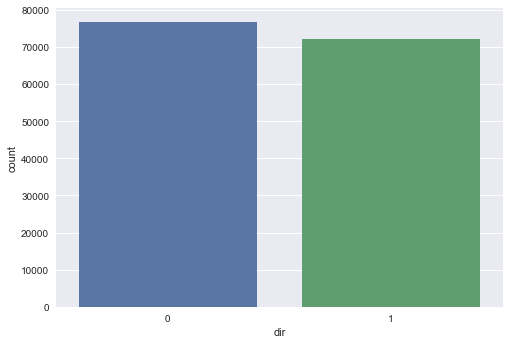

In [17]:
sns.countplot(x=df['dir'])

## Train Test Split

In [18]:
split = int(len(df)*0.7)
split

104173

In [19]:
train = df.iloc[:split].copy()
test = df.iloc[split:].copy()

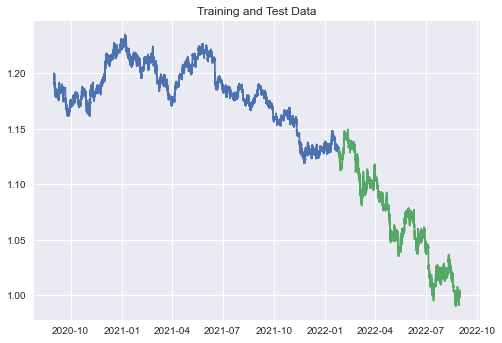

In [20]:

plt.plot(train.close)
plt.plot(test.close)
plt.title("Training and Test Data")
plt.show()

# Feature Scaling

In [21]:
train[cols]

,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,bol1_lag_1,bol1_lag_2,bol1_lag_3,bol1_lag_4,bol1_lag_5,bol2_lag_1,bol2_lag_2,bol2_lag_3,bol2_lag_4,bol2_lag_5,min_lag_1,min_lag_2,min_lag_3,min_lag_4,min_lag_5,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-01 04:35:00,1.0,0.0,0.0,0.0,1.0,0.001828,0.001834,0.001837,0.001831,0.001830,1.200007,1.200197,1.200351,1.200458,1.200514,1.198125,1.197753,1.197427,1.197126,1.196878,-0.001893,-0.001693,-0.001918,-0.002035,-0.002109,0.000183,0.000392,0.000267,0.000250,0.000175,0.000022,-0.000072,-0.000028,0.000117,0.000114,0.000410,0.000409,0.000407,0.000407,0.000408
2020-09-01 04:40:00,0.0,1.0,0.0,0.0,0.0,0.001814,0.001828,0.001834,0.001837,0.001831,1.199603,1.200007,1.200197,1.200351,1.200458,1.198691,1.198125,1.197753,1.197427,1.197126,-0.000284,-0.001893,-0.001693,-0.001918,-0.002035,0.000392,0.000183,0.000392,0.000267,0.000250,-0.000042,0.000022,-0.000072,-0.000028,0.000117,0.000414,0.000410,0.000409,0.000407,0.000407
2020-09-01 04:45:00,1.0,0.0,1.0,0.0,0.0,0.001714,0.001814,0.001828,0.001834,0.001837,1.199595,1.199603,1.200007,1.200197,1.200351,1.198688,1.198691,1.198125,1.197753,1.197427,-0.000292,-0.000284,-0.001893,-0.001693,-0.001918,0.000384,0.000392,0.000183,0.000392,0.000267,0.000003,-0.000042,0.000022,-0.000072,-0.000028,0.000199,0.000414,0.000410,0.000409,0.000407
2020-09-01 04:50:00,0.0,1.0,0.0,1.0,0.0,0.001609,0.001714,0.001814,0.001828,0.001834,1.199583,1.199595,1.199603,1.200007,1.200197,1.198675,1.198688,1.198691,1.198125,1.197753,-0.000175,-0.000292,-0.000284,-0.001893,-0.001693,0.000500,0.000384,0.000392,0.000183,0.000392,-0.000106,0.000003,-0.000042,0.000022,-0.000072,0.000200,0.000199,0.000414,0.000410,0.000409
2020-09-01 04:55:00,0.0,0.0,1.0,0.0,1.0,0.001513,0.001609,0.001714,0.001814,0.001828,1.199578,1.199583,1.199595,1.199603,1.200007,1.198688,1.198675,1.198688,1.198691,1.198125,-0.000142,-0.000175,-0.000292,-0.000284,-0.001893,0.000534,0.000500,0.000384,0.000392,0.000183,-0.000047,-0.000106,0.000003,-0.000042,0.000022,0.000186,0.000200,0.000199,0.000414,0.000410
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25 15:05:00,0.0,0.0,0.0,1.0,1.0,-0.000101,-0.000142,-0.000164,-0.000185,-0.000210,1.127964,1.127982,1.127973,1.127956,1.127908,1.126692,1.126648,1.126644,1.126648,1.126666,-0.000302,-0.000585,-0.000772,-0.000922,-0.000603,0.000798,0.000514,0.000328,0.000177,0.000497,-0.000207,-0.000006,0.000109,0.000269,0.000160,0.000268,0.000277,0.000277,0.000275,0.000274
2022-01-25 15:10:00,0.0,0.0,0.0,0.0,1.0,-0.000085,-0.000101,-0.000142,-0.000164,-0.000185,1.127965,1.127964,1.127982,1.127973,1.127956,1.126686,1.126692,1.126648,1.126644,1.126648,-0.000266,-0.000302,-0.000585,-0.000772,-0.000922,0.000834,0.000798,0.000514,0.000328,0.000177,-0.000169,-0.000207,-0.000006,0.000109,0.000269,0.000261,0.000268,0.000277,0.000277,0.000275
2022-01-25 15:15:00,1.0,0.0,0.0,0.0,0.0,-0.000061,-0.000085,-0.000101,-0.000142,-0.000164,1.127977,1.127965,1.127964,1.127982,1.127973,1.126695,1.126686,1.126692,1.126648,1.126644,-0.000630,-0.000266,-0.000302,-0.000585,-0.000772,0.000470,0.000834,0.000798,0.000514,0.000328,0.000015,-0.000169,-0.000207,-0.000006,0.000109,0.000271,0.000261,0.000268,0.000277,0.000277


In [22]:
mu, std = train.mean(), train.std() # train set parameters (mu--> mean, std ---> std deviation) for standardization

In [23]:
params = {"mu":mu, "std":std}
pkl.dump(params, open("datasets/params.pkl", "wb"))

In [24]:
Z_train = (train - mu) / std # standardization of train set features
Z_train

,close,returns,dir,sma,bol1,bol2,min,max,mom,vol,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,bol1_lag_1,bol1_lag_2,bol1_lag_3,bol1_lag_4,bol1_lag_5,bol2_lag_1,bol2_lag_2,bol2_lag_3,bol2_lag_4,bol2_lag_5,min_lag_1,min_lag_2,min_lag_3,min_lag_4,min_lag_5,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-09-01 04:35:00,0.616522,-0.931404,-0.969521,3.585997,0.603089,0.632206,0.506163,-0.321094,-0.330094,2.015055,1.031428,-0.969502,-0.969502,-0.969483,1.031448,3.612894,3.625225,3.630076,3.618008,3.616565,0.617726,0.624598,0.630146,0.634013,0.636046,0.611643,0.598106,0.586272,0.575338,0.566299,-1.885763,-1.588797,-1.923087,-2.096496,-2.207733,-0.607010,-0.321090,-0.492648,-0.515516,-0.618421,0.183334,-0.575612,-0.218433,0.942451,0.920035,1.980247,1.972035,1.953167,1.954791,1.955108
2020-09-01 04:40:00,0.616885,0.040010,1.031428,3.388812,0.602801,0.632088,0.493770,-0.332533,0.027084,0.027343,-0.969521,1.031448,-0.969502,-0.969483,-0.969502,3.585739,3.612632,3.624960,3.629812,3.617745,0.603075,0.617712,0.624583,0.630131,0.633998,0.632192,0.611629,0.598091,0.586258,0.575323,0.506170,-1.885723,-1.588748,-1.923026,-2.096423,-0.321094,-0.607006,-0.321084,-0.492645,-0.515507,-0.330089,0.183344,-0.575607,-0.218440,0.942433,2.015008,1.980200,1.971990,1.953124,1.954746
2020-09-01 04:45:00,0.611806,-0.520504,-0.969521,3.183754,0.602387,0.631631,0.667292,-0.172370,-0.843547,0.038341,1.031428,-0.969502,1.031448,-0.969483,-0.969502,3.388565,3.585478,3.612368,3.624697,3.629549,0.602786,0.603060,0.617697,0.624569,0.630117,0.632074,0.632178,0.611615,0.598077,0.586243,0.493777,0.506184,-1.885668,-1.588694,-1.922957,-0.332533,-0.321090,-0.607000,-0.321081,-0.492635,0.027090,-0.330079,0.183349,-0.575613,-0.218463,0.027330,2.014961,1.980154,1.971946,1.953078
2020-09-01 04:50:00,0.610355,-0.146838,-0.969521,2.994047,0.602208,0.632101,0.716877,-0.126602,-0.374792,-0.092668,-0.969521,1.031448,-0.969502,1.031467,-0.969502,3.183521,3.388317,3.585216,3.612106,3.624434,0.602372,0.602771,0.603045,0.617682,0.624554,0.631617,0.632060,0.632164,0.611601,0.598063,0.667296,0.493791,0.506199,-1.885608,-1.588633,-0.172370,-0.332529,-0.321084,-0.606996,-0.321072,-0.843543,0.027100,-0.330074,0.183340,-0.575637,0.038328,0.027316,2.014915,1.980110,1.971900
2020-09-01 04:55:00,0.603826,-0.670087,-0.969521,2.794106,0.602618,0.630761,0.927651,0.079389,-0.799053,-0.113613,-0.969521,-0.969502,1.031448,-0.969483,1.031448,2.993826,3.183286,3.388068,3.584955,3.611843,0.602193,0.602357,0.602756,0.603030,0.617668,0.632087,0.631603,0.632046,0.632150,0.611587,0.716880,0.667308,0.493806,0.506208,-1.885541,-0.126603,-0.172367,-0.332523,-0.321081,-0.606987,-0.374787,-0.843533,0.027105,-0.330081,0.183320,-0.092679,0.038314,0.027303,2.014870,1.980065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25 15:05:00,-1.996329,-0.156368,-0.969521,-0.150294,-1.993367,-1.982557,0.531982,0.285022,-1.348746,0.602046,-0.969521,-0.969502,-0.969502,1.031467,1.031448,-0.182591,-0.262895,-0.306199,-0.348319,-0.397122,-1.993462,-1.992879,-1.993241,-1.993920,-1.995709,-1.982405,-1.984067,-1.984288,-1.984190,-1.983591,0.479250,0.057492,-0.219139,-0.442992,0.031207,0.236322,-0.153151,-0.408619,-0.615357,-0.177468,-1.657285,-0.042713,0.883296,2.165629,1.287222,0.668804,0.747175,0.747157,0.729722,0.719046
2022-01-25 15:10:00,-1.981456,1.632256,1.031428,-0.104245,-1.992914,-1.982226,-0.008423,-0.213990,0.123477,0.692511,-0.969521,-0.969502,-0.969502,-0.969483,1.031448,-0.150319,-0.182614,-0.262913,-0.306216,-0.348333,-1.993426,-1.993522,-1.992938,-1.993300,-1.993979,-1.982616,-1.982464,-1.984126,-1.984346,-1.984249,0.531989,0.479264,0.05751

In [25]:
Z_train.describe()

,close,returns,dir,sma,bol1,bol2,min,max,mom,vol,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,bol1_lag_1,bol1_lag_2,bol1_lag_3,bol1_lag_4,bol1_lag_5,bol2_lag_1,bol2_lag_2,bol2_lag_3,bol2_lag_4,bol2_lag_5,min_lag_1,min_lag_2,min_lag_3,min_lag_4,min_lag_5,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5
count,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05,1.041730e+05
mean,9.782868e-13,-1.420559e-16,-6.706483e-15,-2.093863e-16,-1.275763e-13,4.861774e-13,-6.342447e-15,-4.378176e-15,-6.004538e-17,-2.010483e-14,-7.126218e-15,4.418074e-16,4.284419e-16,5.299846e-15,4.342140e-16,-1.729811e-17,8.012203e-17,1.544737e-16,8.658893e-17,-8.121942e-17,-1.301750e-13,-1.237716e-13,-1.207784e-13,-1.205885e-13,-1.120873e-13,4.857164e-13,4.925740e-13,4.899062e-13,4.926013e-13,4.866608e-13,-1.366136e-14,-1.138400e-14,6.470090e-15,-4.387501e-15,6.450670e-15,-5.520076e-15,1.263564e-14,6.678422e-15,-9.464253e-15,-2.426885e-15,-3.246592e-17,4.586452e-18,2.053286e-17,-2.337615e-17,-3.423187e-17,-2.033794e-14,-1.958001e-14,-2.082126e-14,-1.858833e-14,-1.948572e-14
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-2.297407e+00,-2.335749e+01,-9.695206e-01,-8.770174e+00,-2.291749e+00,-2.272014e+00,-1.135273e+01,-8.585174e-01,-1.590757e+01,-1.630492e+00,-9.695206e-01,-9.695019e-01,-9.695019e-01,-9.694833e-01,-9.695019e-01,-8.769659e+00,-8.769140e+00,-8.768621e+00,-8.768106e+00,-8.767593e+00,-2.291813e+00,-2.291878e+00,-2.291942e+00,-2.292007e+00,-2.292071e+00,-2.272077e+00,-2.272141e+00,-2.272204e+00,-2.272268e+00,-2.272332e+00,-1.135253e+01,-1.135238e+01,-1.135217e+01,-1.135191e+01,-1.135163e+01,-8.585179e-01,-8.585139e-01,-8.585073e-01,-8.585035e-01,-8.584936e-01,-1.590761e+01,-1.590759e+01,-1.590759e+01,-1.590753e+01,-1.590763e+01,-1.630477e+00,-1.630463e+00,-1.630449e+00,-1.630435e+00,-1.630420e+00
25%,-5.192321e-01,-4.487459e-01,-9.695206e-01,-4.663422e-01,-5.193313e-01,-5.166601e-01,-3.562531e-01,-6.546557e-01,-4.510337e-01,-7.284065e-01,-9.695206e-01,-9.695019e-01,-9.695019e-01,-9.694833e-01,-9.695019e-01,-4.663469e-01,-4.663520e-01,-4.663576e-01,-4.663641e-01,-4.663710e-01,-5.192673e-01,-5.192024e-01,-5.192192e-01,-5.192114e-01,-5.192012e-01,-5.166236e-01,-5.165838e-01,-5.166173e-01,-5.166366e-01,-5.166224e-01,-3.562450e-01,-3.562649e-01,-3.562654e-01,-3.562517e-01,-3.562294e-01,-6.546562e-01,-6.546523e-01,-6.546459e-01,-6.546424e-01,-6.546327e-01,-4.510289e-01,-4.510187e-01,-4.510139e-01,-4.510199e-01,-4.510438e-01,-7.284069e-01,-7.284078e-01,-7.284086e-01,-7.284091e-01,-7.284100e-01
50%,4.737525e-02,2.644474e-03,-9.695206e-01,1.973386e-02,4.531120e-02,4.533800e-02,2.908847e-01,-2.999487e-01,4.759144e-03,-2.107161e-01,-

In [26]:
# standardization of test set features (with train set parameters)

Z_test = (test - mu) / std 

In [27]:
Z_train = Z_train[cols]
y_train = train['dir']
Z_test = Z_test[cols]


## Creating and Fitting the DNN Model

In [28]:

def set_seeds(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def cw(df):  #class weight imbalance
    c0, c1 = np.bincount(df["dir"])
    w0 = (1/c0) * (len(df)) / 2
    w1 = (1/c1) * (len(df)) / 2
    return {0:w0, 1:w1}

optimizer = Adam(learning_rate = 0.0001)

def create_model(hl = 2, hu = 100, dropout = False, rate = 0.3, regularize = False,
                 reg = l1(0.0005), optimizer = optimizer, input_dim = None):
    if not regularize:
        reg = None
    model = tf.keras.Sequential()
    model.add(Dense(hu, input_dim = input_dim, activity_regularizer = reg ,activation = "relu"))
    if dropout: 
        model.add(Dropout(rate, seed = 42))
    for layer in range(hl):
        model.add(Dense(hu, activation = "relu", activity_regularizer = reg))
        if dropout:
            model.add(Dropout(rate, seed = 42))
    model.add(Dense(1, activation = "sigmoid"))
    model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])
    return model


In [29]:
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
mc = ModelCheckpoint('datasets/best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)


In [30]:
# fitting a DNN model with 3 Hidden Layers (50 nodes each) and dropout regularization

set_seeds(42)
model = create_model(hl = 3, hu = 40, dropout = True, input_dim = len(cols))
history = model.fit(x = Z_train, y = y_train , epochs = 200, verbose = False,
          validation_split = 0.2, shuffle = False, class_weight = cw(df), callbacks = [es,mc])




Epoch 1: val_accuracy improved from -inf to 0.51941, saving model to datasets\best_model.h5

Epoch 2: val_accuracy did not improve from 0.51941

Epoch 3: val_accuracy did not improve from 0.51941

Epoch 4: val_accuracy did not improve from 0.51941

Epoch 5: val_accuracy did not improve from 0.51941

Epoch 6: val_accuracy improved from 0.51941 to 0.51961, saving model to datasets\best_model.h5

Epoch 7: val_accuracy did not improve from 0.51961

Epoch 8: val_accuracy did not improve from 0.51961

Epoch 9: val_accuracy did not improve from 0.51961

Epoch 10: val_accuracy did not improve from 0.51961

Epoch 11: val_accuracy did not improve from 0.51961
Epoch 11: early stopping


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


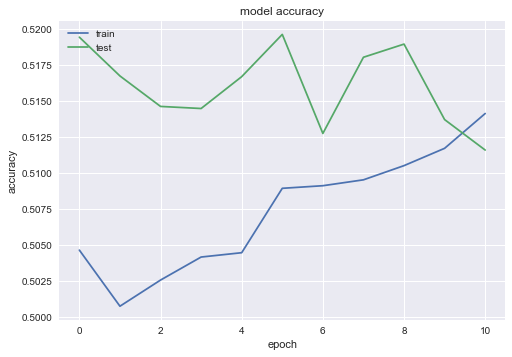

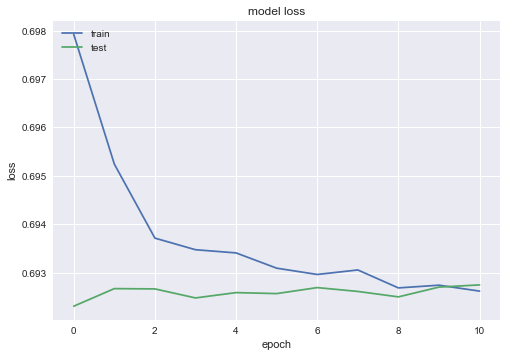

In [31]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
# Call back the best Epoch model

DNN_model = load_model('datasets/best_model.h5')

In [33]:
y_pred = DNN_model.predict(Z_train) # prediction (probabilities)
y_pred

3256/3256 [==============================] - 10s 3ms/step


array([[0.49302658],
       [0.4958614 ],
       [0.49611673],
       ...,
       [0.49794167],
       [0.4981146 ],
       [0.49826172]], dtype=float32)

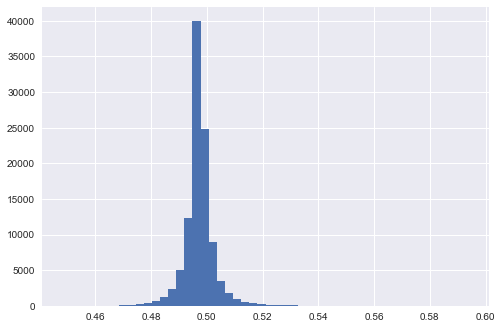

In [34]:
plt.hist(y_pred, bins = 50)
plt.show()

# Test Set prediction

In [35]:
#train evaluation
DNN_model.evaluate(Z_train,y_train)

3256/3256 [==============================] - 12s 4ms/step - loss: 0.6927 - accuracy: 0.5210


[0.6926700472831726, 0.521008312702179]

In [36]:
#test evaluation
DNN_model.evaluate(Z_test[cols], test["dir"])

1396/1396 [==============================] - 5s 4ms/step - loss: 0.6932 - accuracy: 0.5054


[0.6932249665260315, 0.5053980350494385]

# The model Generalize well.  
Train Accuracy = 0.5210   
Test Accuracy = 0.5054  
% diff = 2.99%

In [37]:
y_pred_train = DNN_model.predict(Z_train) # prediction (probabilities)
y_pred_train

3256/3256 [==============================] - 10s 3ms/step


array([[0.49302658],
       [0.4958614 ],
       [0.49611673],
       ...,
       [0.49794167],
       [0.4981146 ],
       [0.49826172]], dtype=float32)

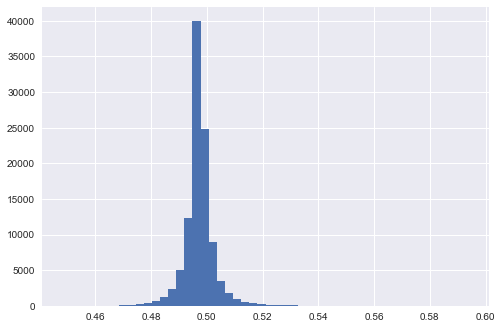

In [38]:
plt.hist(y_pred_train, bins = 50)
plt.show()

# Confusion Matrix

In [39]:
#converting probability to class
test_prob = DNN_model.predict(Z_test[cols]) # prediction (probabilities)
y_pred_test = pd.DataFrame(np.round(test_prob))
y_pred_test.value_counts()

1396/1396 [==============================] - 5s 3ms/step


1.0    28038
0.0    16608
dtype: int64

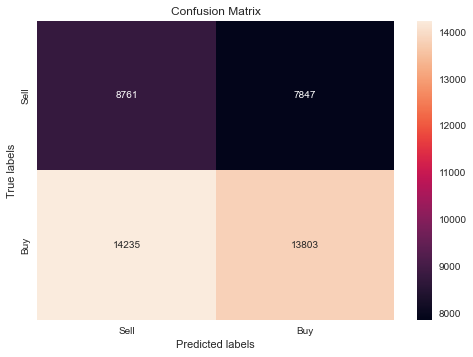

In [40]:
cm = confusion_matrix(y_pred_test, test.dir)

# Plotting the confusion matrix

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Sell','Buy']); ax.yaxis.set_ticklabels(['Sell','Buy']);

# buy sell or hold


The prediction probalility shows the strength of the assigned class.  
a high probalility means a strong Buy indicator    
while a low probability means a strong sell indicator.

In [59]:
DNN_model.save("datasets/DNN_model")

INFO:tensorflow:Assets written to: datasets/DNN_model\assets


## In-Sample Backtesting

In [61]:
train["strategy"] = train.pred * train.returns
train["creturns"] = train["returns"].cumsum().apply(np.exp)
train["cstrategy"] = train["strategy"].cumsum().apply(np.exp)

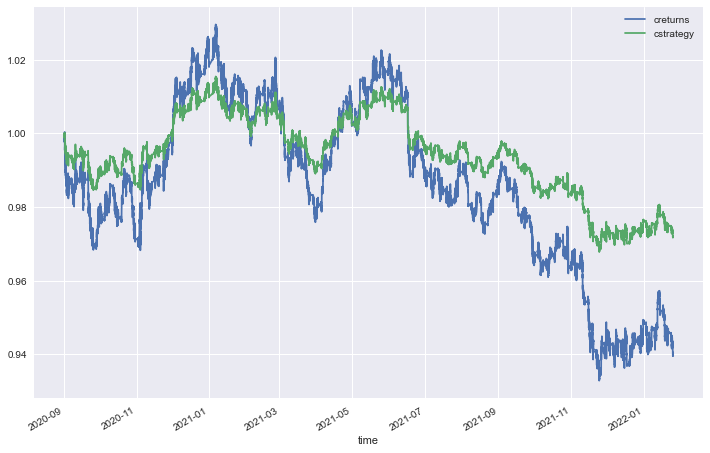

In [62]:
train[["creturns", "cstrategy"]].plot(figsize = (12 , 8))
plt.show()

# Out-Sample Forward Testing

In [41]:
test["proba"] = DNN_model.predict(Z_test[cols])

1396/1396 [==============================] - 5s 3ms/step


In [42]:
test["position"] = np.where(test.proba < 0.47, -1, np.nan) # 1. short where proba < 0.47

In [43]:
test["position"] = np.where(test.proba > 0.53, 1, test.position) # 2. long where proba > 0.53

In [44]:
#creating a column to show New york time
#we typically want to trade during new york timing as it has the highest volatility
test.index = test.index.tz_localize("UTC")
test["NYTime"] = test.index.tz_convert("America/New_York")
test["hour"] = test.NYTime.dt.hour

In [45]:
test["position"] = np.where(~test.hour.between(2, 12), 0, test.position) # 3. neutral in non-busy hours

In [46]:
test["position"] = test.position.ffill().fillna(0) # 4. in all other cases: hold position

In [47]:
test.position.value_counts(dropna = False)

 0.0    32593
 1.0    11558
-1.0      495
Name: position, dtype: int64

In [48]:
test["strategy"] = test["position"] * test["returns"]

In [49]:
test["creturns"] = test["returns"].cumsum().apply(np.exp)
test["cstrategy"] = test["strategy"].cumsum().apply(np.exp)


In [50]:
test

,close,returns,dir,sma,bol1,bol2,min,max,mom,vol,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,bol1_lag_1,bol1_lag_2,bol1_lag_3,bol1_lag_4,bol1_lag_5,bol2_lag_1,bol2_lag_2,bol2_lag_3,bol2_lag_4,bol2_lag_5,min_lag_1,min_lag_2,min_lag_3,min_lag_4,min_lag_5,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5,proba,position,NYTime,hour,strategy,creturns,cstrategy
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-25 15:30:00+00:00,1.12782,-0.000018,0,0.000039,1.128009,1.126762,-0.000807,0.000177,0.000171,0.000263,1.0,1.0,0.0,1.0,0.0,0.000031,0.000008,-0.000022,-0.000061,-0.000085,1.127994,1.127949,1.127954,1.127977,1.127965,1.126768,1.126782,1.126755,1.126695,1.126686,-0.000825,-0.000319,-0.000293,-0.000630,-0.000266,0.000160,0.000665,0.000692,0.000470,0.000834,0.000103,5.618767e-05,3.548679e-05,1.478242e-05,-1.685346e-04,0.000268,0.000259,0.000262,0.000271,0.000261,0.480200,0.0,2022-01-25 10:30:00-05:00,10,-0.0,0.999982,1.000000
2022-01-25 15:35:00+00:00,1.12754,-0.000248,0,0.000038,1.127995,1.126765,-0.000559,0.000426,0.000080,0.000268,0.0,1.0,1.0,0.0,1.0,0.000039,0.000031,0.000008,-0.000022,-0.000061,1.128009,1.127994,1.127949,1.127954,1.127977,1.126762,1.126768,1.126782,1.126755,1.126695,-0.000807,-0.000825,-0.000319,-0.000293,-0.000630,0.000177,0.000160,0.000665,0.000692,0.000470,0.000171,1.034586e-04,5.618767e-05,3.548679e-05,1.478242e-05,0.000263,0.000268,0.000259,0.000262,0.000271,0.489948,0.0,2022-01-25 10:35:00-05:00,10,-0.0,0.999734,1.000000
2022-01-25 15:40:00+00:00,1.12744,-0.000089,0,0.000020,1.127912,1.126801,-0.000470,0.000355,-0.000118,0.000261,0.0,0.0,1.0,1.0,0.0,0.000038,0.000039,0.000031,0.000008,-0.000022,1.127995,1.128009,1.127994,1.127949,1.127954,1.126765,1.126762,1.126768,1.126782,1.126755,-0.000559,-0.000807,-0.000825,-0.000319,-0.000293,0.000426,0.000177,0.000160,0.000665,0.000692,0.000080,1.714662e-04,1.034586e-04,5.618767e-05,3.548679e-05,0.000268,0.000263,0.000268,0.000259,0.000262,0.497675,0.0,2022-01-25 10:40:00-05:00,10,-0.0,0.999645,1.000000
2022-01-25 15:45:00+00:00,1.12748,0.000035,1,0.000015,1.127896,1.126804,-0.000506,0.000319,-0.000101,0.000252,0.0,0.0,0.0,1.0,1.0,0.000020,0.000038,0.000039,0.000031,0.000008,1.127912,1.127995,1.128009,1.127994,1.127949,1.126801,1.126765,1.126762,1.126768,1.126782,-0.000470,-0.000559,-0.000807,-0.000825,-0.000319,0.000355,0.000426,0.000177,0.000160,0.000665,-0.000118,7.982934e-05,1.714662e-04,1.034586e-04,5.618767e-05,0.000261,0.000268,0.000263,0.000268,0.000259,0.503918,0.0,2022-01-25 10:45:00-05:00,10,0.0,0.999681,1.000000
2022-01-25 15:50:00+00:00,1.12783,0.000310,1,0.000035,1.127950,1.126799,-0.000816,0.000009,0.000086,0.000248,1.0,0.0,0.0,0.0,1.0,0.000015,0.000020,0.000038,0.000039,0.000031,1.127896,1.127912,1.127995,1.128009,1.127994,1.126804,1.126801,1.126765,1.126762,1.126768,-0.000506,-0.000470,-0.000559,-0.000807,-0.000825,0.000319,0.000355,0.000426,0.000177,0.000160,-0.000101,-1.182410e-04,7.982934e-05,1.714662e-04,1.034586e-04,0.000252,0.000261,0.000268,0.000263,0.000268,0.497607,0.0,2022-01-25 10:50:00-05:00,10,0.0,0.999991,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30 23:35:00+00:00,1.00218,-0.000140,0,0.000041,1.002333,1.001435,-0.000649,0.000140,0.000013,0.000118,1.0,1.0,1.0,0.0,1.0,0.000017,-0.000015,-0.000052,-0.000090,-0.000131,1.002304,1.002242,1.002202,1.002165,1.002137,1.001421,1.001429,1.001425,1.001419,1.001394,-0.000788,-0.000649,-0.000609,-0.000579,-0.000718,0.000000,0.000000,0.000040,0.000070,0.000000,0.000070,-4.856322e-18,2.328432e-05,7.651402e-05,1.530349e-04,0.000113,0.000111,0.000111,0.000113,0.000113,0.485622,0.0,2022-08-30 19:35:00-04:00,19,-0.0,0.888583,0.

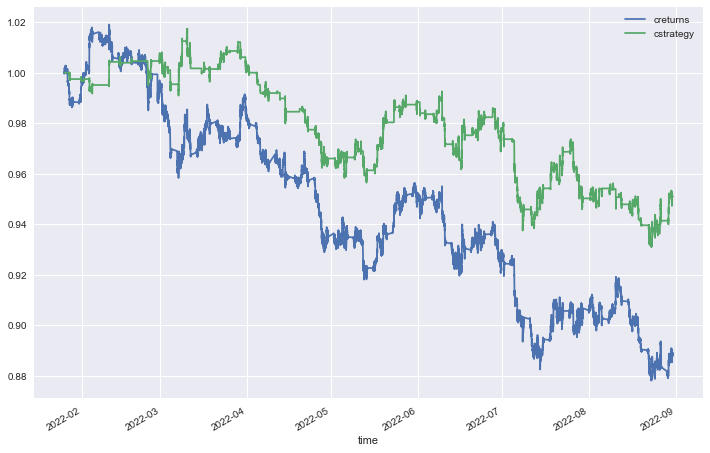

In [51]:
test[["creturns", "cstrategy"]].plot(figsize = (12, 8))
plt.show()

In [52]:
ptc = 0.00005

In [53]:
test["trades"] = test.position.diff().abs()

In [54]:
test.trades.value_counts()

0.0    44355
1.0      266
2.0       24
Name: trades, dtype: int64

In [55]:
test["strategy_net"] = test.strategy - test.trades * ptc

In [56]:
test["cstrategy_net"] = test["strategy_net"].cumsum().apply(np.exp)

In [57]:
test

,close,returns,dir,sma,bol1,bol2,min,max,mom,vol,dir_lag_1,dir_lag_2,dir_lag_3,dir_lag_4,dir_lag_5,sma_lag_1,sma_lag_2,sma_lag_3,sma_lag_4,sma_lag_5,bol1_lag_1,bol1_lag_2,bol1_lag_3,bol1_lag_4,bol1_lag_5,bol2_lag_1,bol2_lag_2,bol2_lag_3,bol2_lag_4,bol2_lag_5,min_lag_1,min_lag_2,min_lag_3,min_lag_4,min_lag_5,max_lag_1,max_lag_2,max_lag_3,max_lag_4,max_lag_5,mom_lag_1,mom_lag_2,mom_lag_3,mom_lag_4,mom_lag_5,vol_lag_1,vol_lag_2,vol_lag_3,vol_lag_4,vol_lag_5,proba,position,NYTime,hour,strategy,creturns,cstrategy,trades,strategy_net,cstrategy_net
time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-01-25 15:30:00+00:00,1.12782,-0.000018,0,0.000039,1.128009,1.126762,-0.000807,0.000177,0.000171,0.000263,1.0,1.0,0.0,1.0,0.0,0.000031,0.000008,-0.000022,-0.000061,-0.000085,1.127994,1.127949,1.127954,1.127977,1.127965,1.126768,1.126782,1.126755,1.126695,1.126686,-0.000825,-0.000319,-0.000293,-0.000630,-0.000266,0.000160,0.000665,0.000692,0.000470,0.000834,0.000103,5.618767e-05,3.548679e-05,1.478242e-05,-1.685346e-04,0.000268,0.000259,0.000262,0.000271,0.000261,0.480200,0.0,2022-01-25 10:30:00-05:00,10,-0.0,0.999982,1.000000,NaN,NaN,NaN
2022-01-25 15:35:00+00:00,1.12754,-0.000248,0,0.000038,1.127995,1.126765,-0.000559,0.000426,0.000080,0.000268,0.0,1.0,1.0,0.0,1.0,0.000039,0.000031,0.000008,-0.000022,-0.000061,1.128009,1.127994,1.127949,1.127954,1.127977,1.126762,1.126768,1.126782,1.126755,1.126695,-0.000807,-0.000825,-0.000319,-0.000293,-0.000630,0.000177,0.000160,0.000665,0.000692,0.000470,0.000171,1.034586e-04,5.618767e-05,3.548679e-05,1.478242e-05,0.000263,0.000268,0.000259,0.000262,0.000271,0.489948,0.0,2022-01-25 10:35:00-05:00,10,-0.0,0.999734,1.000000,0.0,-0.0,1.000000
2022-01-25 15:40:00+00:00,1.12744,-0.000089,0,0.000020,1.127912,1.126801,-0.000470,0.000355,-0.000118,0.000261,0.0,0.0,1.0,1.0,0.0,0.000038,0.000039,0.000031,0.000008,-0.000022,1.127995,1.128009,1.127994,1.127949,1.127954,1.126765,1.126762,1.126768,1.126782,1.126755,-0.000559,-0.000807,-0.000825,-0.000319,-0.000293,0.000426,0.000177,0.000160,0.000665,0.000692,0.000080,1.714662e-04,1.034586e-04,5.618767e-05,3.548679e-05,0.000268,0.000263,0.000268,0.000259,0.000262,0.497675,0.0,2022-01-25 10:40:00-05:00,10,-0.0,0.999645,1.000000,0.0,-0.0,1.000000
2022-01-25 15:45:00+00:00,1.12748,0.000035,1,0.000015,1.127896,1.126804,-0.000506,0.000319,-0.000101,0.000252,0.0,0.0,0.0,1.0,1.0,0.000020,0.000038,0.000039,0.000031,0.000008,1.127912,1.127995,1.128009,1.127994,1.127949,1.126801,1.126765,1.126762,1.126768,1.126782,-0.000470,-0.000559,-0.000807,-0.000825,-0.000319,0.000355,0.000426,0.000177,0.000160,0.000665,-0.000118,7.982934e-05,1.714662e-04,1.034586e-04,5.618767e-05,0.000261,0.000268,0.000263,0.000268,0.000259,0.503918,0.0,2022-01-25 10:45:00-05:00,10,0.0,0.999681,1.000000,0.0,0.0,1.000000
2022-01-25 15:50:00+00:00,1.12783,0.000310,1,0.000035,1.127950,1.126799,-0.000816,0.000009,0.000086,0.000248,1.0,0.0,0.0,0.0,1.0,0.000015,0.000020,0.000038,0.000039,0.000031,1.127896,1.127912,1.127995,1.128009,1.127994,1.126804,1.126801,1.126765,1.126762,1.126768,-0.000506,-0.000470,-0.000559,-0.000807,-0.000825,0.000319,0.000355,0.000426,0.000177,0.000160,-0.000101,-1.182410e-04,7.982934e-05,1.714662e-04,1.034586e-04,0.000252,0.000261,0.000268,0.000263,0.000268,0.497607,0.0,2022-01-25 10:50:00-05:00,10,0.0,0.999991,1.000000,0.0,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-30 23:35:00+00:00,1.00218,-0.000140,0,0.000041,1.002333,1.001435,-0.000649,0.000140,0.000013,0.000118,1.0,1.0,1.0,0.0,1.0,0.000017,-0.000015,-0.000052,-0.000090,-0.000131,1.002304,1.002242,1.002202,1.002165,1.002137,1.001421,1.001429,1.001425,1.001419,1.001394,-0.000788,-0.000649,-0.000609,-0.000579,-0.000718,0.000000,0.000000,0.000040,0.000070,0.000000,0.000070,-4.856322e-18,2.328432e-0

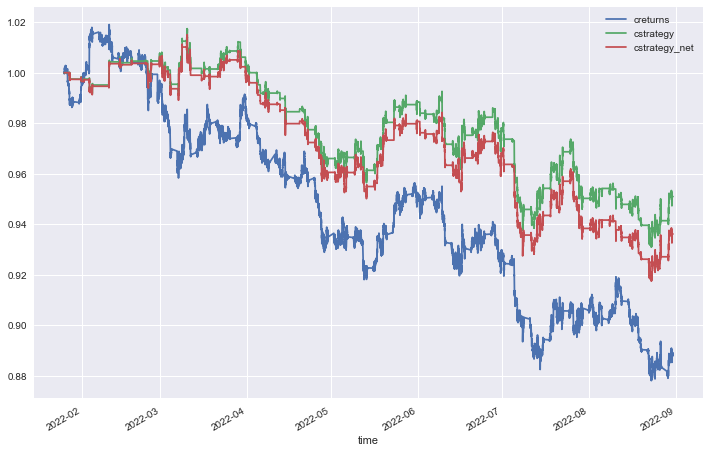

In [58]:
test[["creturns", "cstrategy", "cstrategy_net"]].plot(figsize = (12, 8))
plt.show()